# Transfer learning

In parts 1 and 2 we learned [how to load and run a pre-trained CNN model on our own input](https://github.com/opetrova/TweakingInception/blob/master/GettingStarted.ipynb) and [how to visualize the layers](https://github.com/opetrova/TweakingInception/blob/master/VisualizeLayers.ipynb) of the CNN pre-trained for the purpose of image classification. 

The **pre** in *pre-trained* kind of implies that the training might not be over yet. Indeed, we can go ahead and simply use the pre-trained models for whatever purposes they were originally trained for, but what if we need something more customized? Consider the example of the [Inception CNN model also known as GoogLeNet](https://arxiv.org/abs/1409.4842). The model that has been made available by Google was trained to recognize 1000 categories used in the [ImageNet Challenge](https://en.wikipedia.org/wiki/ImageNet). This thousand happens to not include any labels like *human*, *people*, *girl*, *man*, etc. Can we still somehow use it to determine whether a given image contains people or not? Turns out, this can easily be done via something called **transfer learning**.

### What is transfer learning?

In transfer learning, one uses existing machine learning models to tackle new unsolved problems. This can work remarkably well, especially when the new problem and the one, that the existing model was originally built for, are similar enough.



Take the pre-trained GoogLeNet and train the outer layer on http://pascal.inrialpes.fr/data/human/

In [1]:
import tensorflow as tf
import numpy as np
import os, os.path
import PIL.Image
from IPython.display import clear_output, Image, display
from IPython.display import display
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math
#from IPython.display import Image as _Imgdis

model_fn = 'tensorflow_inception_graph.pb'
mygraph = tf.Graph() 
sess = tf.InteractiveSession(graph=mygraph)

C:\Users\Olga\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Get more data to train on by augmenting it https://github.com/mdbloice/Augmentor

In [2]:
# Get the training images ready to go

import Augmentor

def augment_set(path, num) :
    p = Augmentor.Pipeline(path)
    p.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    p.resize(probability=1.0, width=320, height=240)
    p.sample(num)
    return path + '/output'

M_train = 1000
pos_path = augment_set('INRIAPerson/Train/pos', int(M_train/2))
neg_path = augment_set('INRIAPerson/Train/neg', int(M_train/2))

Initialised with 614 image(s) found.
Output directory set to INRIAPerson/Train/pos\output.

Processing <PIL.Image.Image image mode=RGB size=320x240 at 0x191867C57B8>: 100%|█| 500/500 [00:13<00:00, 36.98 Samples/s]


Initialised with 1218 image(s) found.
Output directory set to INRIAPerson/Train/neg\output.

Processing <PIL.Image.Image image mode=RGB size=320x240 at 0x19186809F98>: 100%|█| 500/500 [00:05<00:00, 93.16 Samples/s]


Store the training images in a Numpy array

In [3]:
#pos_path ='INRIAPerson/Train/pos/output'
#neg_path ='INRIAPerson/Train/neg/output'

# Load the training data :
pos_images = [f for f in os.listdir(pos_path) if os.path.isfile(os.path.join(pos_path, f))]
neg_images = [f for f in os.listdir(neg_path) if os.path.isfile(os.path.join(neg_path, f))]

pos_img_to_array = lambda img: np.array(PIL.Image.open(pos_path+'/'+img))
neg_img_to_array = lambda img: np.array(PIL.Image.open(neg_path+'/'+img))

pos_array = np.asarray(list(map(pos_img_to_array, pos_images)))
neg_array = np.asarray(list(map(neg_img_to_array, neg_images)))

X_train = np.concatenate((pos_array, neg_array), axis=0)
Y_train = np.concatenate((np.ones((pos_array.shape[0],1)),np.zeros((neg_array.shape[0],1))),axis=0)
M = X_train.shape[0]
print("Number of training images: ", M)

# Shuffle the training data
p = np.random.permutation(M)
X_train = X_train[p]
Y_train = Y_train[p]

Number of training images:  1000


Load the pre-trained Inception model

In [4]:
with tf.gfile.FastGFile(model_fn, 'rb') as f: 
    graph_def = tf.GraphDef() 
    graph_def.ParseFromString(f.read())  

X = tf.placeholder(np.float32, shape=(None, X_train.shape[1] , X_train.shape[2], 3), name='input')
Y = tf.placeholder(np.float32, shape=(None, 1))

tf.import_graph_def(graph_def, {'input': X})

In [5]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
 
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

Batch training

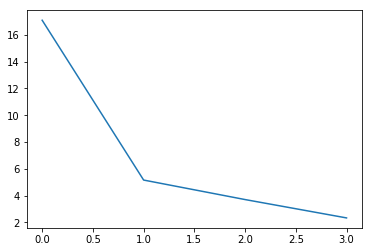

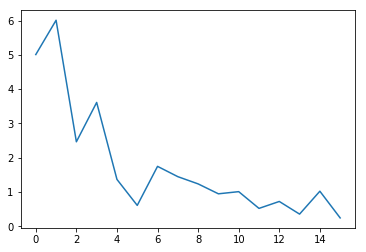

In [6]:
num_epochs = 4
minibatch_size = 256

num_minibatches = int(M / minibatch_size)

pre_trained = mygraph.get_tensor_by_name('import/head1_pool:0')
P = tf.contrib.layers.flatten(pre_trained)
Z = tf.contrib.layers.fully_connected(P, activation_fn=None, num_outputs=1)
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Z, labels = Y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
init = tf.global_variables_initializer()
sess.run(init)

epoch_costs = []
batch_costs = []

for epoch in range(num_epochs):
        
    epoch_cost = 0.
    minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

    for minibatch in minibatches:
        
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        _ , batch_cost = sess.run([optimizer,cost], feed_dict = {X:minibatch_X, Y:minibatch_Y})
        batch_costs.append(batch_cost)
        epoch_cost += batch_cost 
        
    epoch_costs.append(epoch_cost)
    
plt.plot(np.squeeze(epoch_costs))
plt.show()
plt.plot(np.squeeze(batch_costs))
plt.show()

Obtain the accuracy on the training set and the test set

In [7]:
predict_op = tf.round(tf.nn.sigmoid(Z))
correct_prediction = tf.equal(predict_op, Y)
    
# Calculate accuracy on the train set
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
print("Train accuracy: ", 100*train_accuracy, "%")

Train accuracy:  97.39999771118164 %


In [13]:
# Load the test images :
pos_path ='INRIAPerson/Test/pos/JPEG'
neg_path ='INRIAPerson/Test/neg/JPEG'

pos_images = [f for f in os.listdir(pos_path) if os.path.isfile(os.path.join(pos_path, f))]
neg_images = [f for f in os.listdir(neg_path) if os.path.isfile(os.path.join(neg_path, f))]

pos_array = np.asarray(list(map(pos_img_to_array, pos_images)))
neg_array = np.asarray(list(map(neg_img_to_array, neg_images)))

X_test = np.concatenate((pos_array, neg_array), axis=0)
Y_test = np.concatenate((np.ones((pos_array.shape[0],1)),np.zeros((neg_array.shape[0],1))),axis=0)
M_test = X_test.shape[0]
print("Number of training images: ", M_test)

Number of training images:  741


In [14]:
# Calculate accuracy on the test set
test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
print("Test accuracy: ", 100*test_accuracy, "%")

Test accuracy:  96.0863709449768 %


Results

In [ ]:
sess.close()